# Obtaining fire-negative locations

Locations where fires did not occur, with an overall similar distribution of Wildfire Hazard Potential (WHP) to the fire-positive locations.

## Wildfire dataset

National Intragency Fire Center:
- Historical wildfires: https://data-nifc.opendata.arcgis.com/datasets/nifc::wfigs-wildland-fire-locations-full-history/about

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
base_dir = 'drive/MyDrive/Senior Year/ML & Climate/ML-Climate-Final-Project-Template/src'
os.chdir(base_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## WHP dataset 

Dillon, Gregory K; Gilbertson-Day, Julie W. 2020. Wildfire Hazard Potential for the United States (270-m), version 2020. 3rd Edition. Fort Collins, CO: Forest Service Research Data Archive. https://doi.org/10.2737/RDS-2015-0047-3

The data presented here are the product of modeling, and as such carry an inherent degree of error and uncertainty. Users are strongly encouraged to read and fully comprehend the metadata and other available documentation prior to data use. No warranty is made by the Originator as to the accuracy, reliability, or completeness of these data for individual use or aggregate use with other data, or for purposes not intended by the Originator. These datasets are intended to provide nationally-consistent information for the purpose of comparing relative wildfire risk among communities nationally or within a state or county. Data included here are not intended to replace locally-calibrated state, regional, or local risk assessments where they exist. It is the responsibility of the user to be familiar with the value, assumptions, and limitations of these national data publications. Managers and planners must evaluate these data according to the scale and requirements specific to their needs. Spatial information may not meet National Map Accuracy Standards. This information may be updated without notification.

In [29]:
import rioxarray as rxr
import rasterio

whp_raster = rxr.open_rasterio("data/whp2020_GeoTIF/whp2020_cls_conus.tif", masked=True).squeeze()
whp_raster2 = rasterio.open("data/whp2020_GeoTIF/whp2020_cls_conus.tif")
whp_raster2.crs

CRS.from_epsg(5070)

In [30]:
# ! pip install earthpy

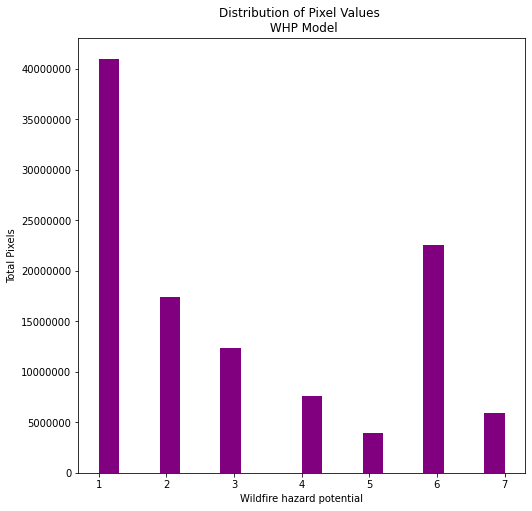

In [31]:
import earthpy as et
import earthpy.plot as ep

# Explore the data by plotting a histogram with earthpy
ax = ep.hist(whp_raster.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Wildfire hazard potential",
             ylabel="Total Pixels",
             title="Distribution of Pixel Values \n WHP Model")

# Turn off scientific notation
ax[1].ticklabel_format(useOffset=False,
                       style='plain')

# Fire risk (1-5), non-burnable lands (6), and open water (7) 

In [32]:
import geopandas as gpd

fires_gdf = gpd.read_file("data/NIFC_Wildland_Fire_Perimeters.gdb")

In [33]:
proj_gdf = fires_gdf.to_crs(5070)
# '+proj=merc +a=6378137 +b=6378137 +lat_ts=0.0 +lon_0=0.0 +x_0=0.0 +y_0=0 +k=1.0 +units=m +nadgrids=@null +wktext  +no_defs


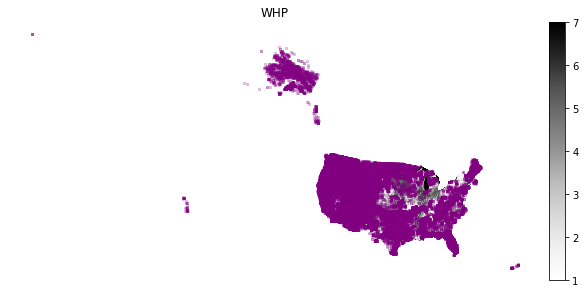

In [34]:
from matplotlib import pyplot as plt
from rasterio.plot import plotting_extent

fig, ax = plt.subplots(figsize=(10, 10))

# We plot with the zeros in the data so the CHM can be better represented visually
ep.plot_bands(whp_raster,
              extent=plotting_extent(whp_raster,
                                     whp_raster.rio.transform()),  # Set spatial extent
              cmap='Greys',
              title="WHP",
              scale=False,
              ax=ax)

proj_gdf.plot(ax=ax,
              marker='s',
              markersize=2,
              alpha=0.2,
              color='purple')
ax.set_axis_off()
plt.show()

In [35]:
coord_list = [(x,y) for x,y in zip(proj_gdf['geometry'].x , proj_gdf['geometry'].y)]
coord_list[:10]

[(-657335.8886370335, 2562263.049799819),
 (-2020356.3728325635, 1430482.9756937572),
 (-1406404.8379264094, 2926146.9619063814),
 (-1944013.0106105774, 1340243.972796706),
 (-2133858.2610589587, 2039878.5823191511),
 (658720.3668637436, 912080.0028300082),
 (-1297411.4554180712, 2000592.735756252),
 (-1227533.3458451224, 2506193.1085097883),
 (-522982.494590329, 2244875.9258583956),
 (-2049554.7156279425, 1879164.4341768874)]

In [36]:
# the polygon GeoJSON geometry
# load the raster, mask it by the polygon and crop it
proj_gdf['WildfireHazardPotential'] = [x[0] for x in whp_raster2.sample(coord_list)]
proj_gdf

ABCDMisc ADSPermissionState  CalculatedAcres  \
0          None          CERTIFIED            50.64   
1          None            DEFAULT              NaN   
2          None            DEFAULT              NaN   
3          None            DEFAULT              NaN   
4          None            DEFAULT              NaN   
...         ...                ...              ...   
212233     None            DEFAULT              NaN   
212234     None            DEFAULT              NaN   
212235     None            DEFAULT              NaN   
212236     None            DEFAULT              NaN   
212237     None            DEFAULT              NaN   

              ContainmentDateTime            ControlDateTime  DailyAcres  \
0       2020-08-06T23:13:07+00:00  2020-08-06T23:13:24+00:00        50.6   
1                            None                       None         NaN   
2       2017-10-18T00:30:00+00:00  2017-10-18T00:35:00+00:00        50.0   
3                            None                       None         NaN   
4                            None                       None         NaN   
...                           ...                        ...         ...   
212233                       None                       None         NaN   
212234                       None                       None         1.0   
212235                       None                       None         1.0   
212236                       None                       None         1.0   
212237                       None                       None       117.0   

        DiscoveryAcres DispatchCenterID  EstimatedCostToDate  \
0                 20.0            MTMCC                  NaN   
1                  0.1           CALACC                  NaN   
2                 50.0            MTKIC                  NaN   
3                  NaN           CAMVIC                  NaN   
4                  NaN             None                  NaN   
...                ...              ...                  ...   
212233             NaN            SDGPC                  NaN   
212234             1.0            ILILC                  NaN   
212235             1.0            ILILC                  NaN   
212236             1.0            ILILC                  NaN   
212237             NaN            ARAOC                750.0   

       FinalFireReportApprovedByTitle  ... StrategicDecisionPublishDate  \
0                                None  ...                         None   
1                                None  ...                         None   
2                                None  ...                         None   
3                                None  ...                         None   
4                                None  ...                         None   
...                               ...  ...                          ...   
212233                           None  ...                         None   
212234                           None  ...                         None   
212235                           None  ...                         None   
212236                           None  ...                         None   
212237                           None  ...                         None   

             CreatedOnDateTime_dt      ModifiedOnDateTime_dt Source  \
0       2020-08-06T19:50:29+00:00  2020-08-12T20:46:01+00:00  IRWIN   
1       2020-02-28T20:52:36+00:00  2020-02-28T20:52:36+00:00  IRWIN   
2       2017-10-18T13:46:40+00:00  2017-11-09T22:08:19+00:00  IRWIN   
3       2019-07-01T20:10:12+00:00  2019-07-01T20:10:12+00:00  IRWIN   
4       2016-06-20T22:39:02+00:00  2016-06-20T22:39:02+00:00  IRWIN   
...                           ...                        ...    ...   
212233  2022-03-21T13:24:39+00:00  2022-03-21T13:24:39+00:00  IRWIN   
212234  2022-03-21T13:29:12+00:00  2022-03-21T13:46:28+00:00  IRWIN   
212235  2022-03-21T13:36:34+00:00  2022-03-21T13:48:06+00:00  IRWIN   
212236  2022-03-21T13:39:35+00:00  2022-03-21T13:48:2

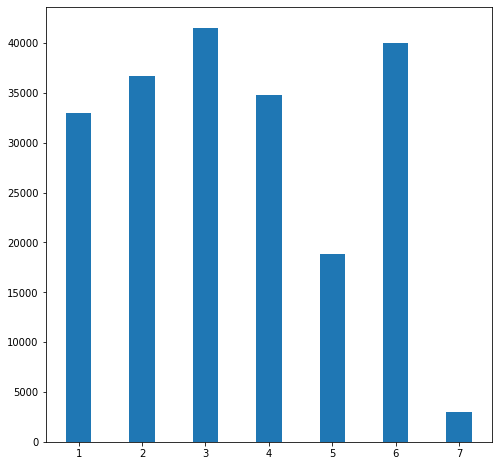

In [43]:
import earthpy as et
import earthpy.plot as ep

plt.figure(figsize=(8, 8))

# Explore the data by plotting a histogram with earthpy
plt.hist(proj_gdf['WildfireHazardPotential'], bins=[x+0.5 for x in range(8)], rwidth=0.4);
